In [1]:
import torch
from torchmdnet import calculators
from torchmdnet.calculators import External

In [3]:
from dms import train

ModuleNotFoundError: No module named 'dms'

In [2]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import tqdm
from scipy.optimize import curve_fit
from moleculekit.molecule import Molecule
from moleculekit.projections.metricrmsd import MetricRmsd

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("whitegrid")

In [1]:
#!wget pub.htmd.org/torchMD_tutorial_data.tar.gz

In [2]:
#!tar -xvf torchMD_tutorial_data.tar.gz

In [9]:
from torchmd_cg.utils.psfwriter import pdb2psf_CA

PDB_file = 'data/chignolin_cln025.pdb'
PSF_file = 'data/chignolin_ca_top.psf'

pdb2psf_CA(PDB_file, PSF_file, bonds = True, angles = False)

2021-08-24 09:12:58,279 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


In [10]:
mol = Molecule('data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('data/chignolin_ca_top.psf')

2021-08-24 09:12:58,990 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


In [11]:
AA2INT = {'ALA':1,
         'GLY':2,
         'PHE':3,
         'TYR':4,
         'ASP':5,
         'GLU':6,
         'TRP':7,
         'PRO':8,
         'ASN':9,
         'GLN':10,
         'HIS':11,
         'HSD':11,
         'HSE':11,
         'SER':12,
         'THR':13,
         'VAL':14,
         'MET':15,
         'CYS':16,
         'NLE':17,
         'ARG':18,
         'LYS':19,
         'LEU':20,
         'ILE':21
         }

emb = np.array([AA2INT[x] for x in mol.resname], dtype='<U3')
np.save('data/chignolin_ca_embeddings.npy', emb)

In [12]:
mol.read('data/chignolin_ca_initial_coords.xtc')

## Analysis

2021-08-23 19:30:01,200 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
/shared/carles/miniconda3/envs/torchmd-net/lib/python3.8/site-packages/moleculekit/align.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  covariance = np.dot(P.T, Q)
/shared/carles/miniconda3/envs/torchmd-net/lib/python3.8/site-packages/moleculekit/align.py:54: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  all1 = np.dot(all1, rot.T)
2021-08-23 19:30:12,621 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
2021-08-23 19:30:14,875 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
2021-08-23 19:30:17,499 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
2021-08-23 19:30:20,093 - moleculekit.molecule - INFO - Removed

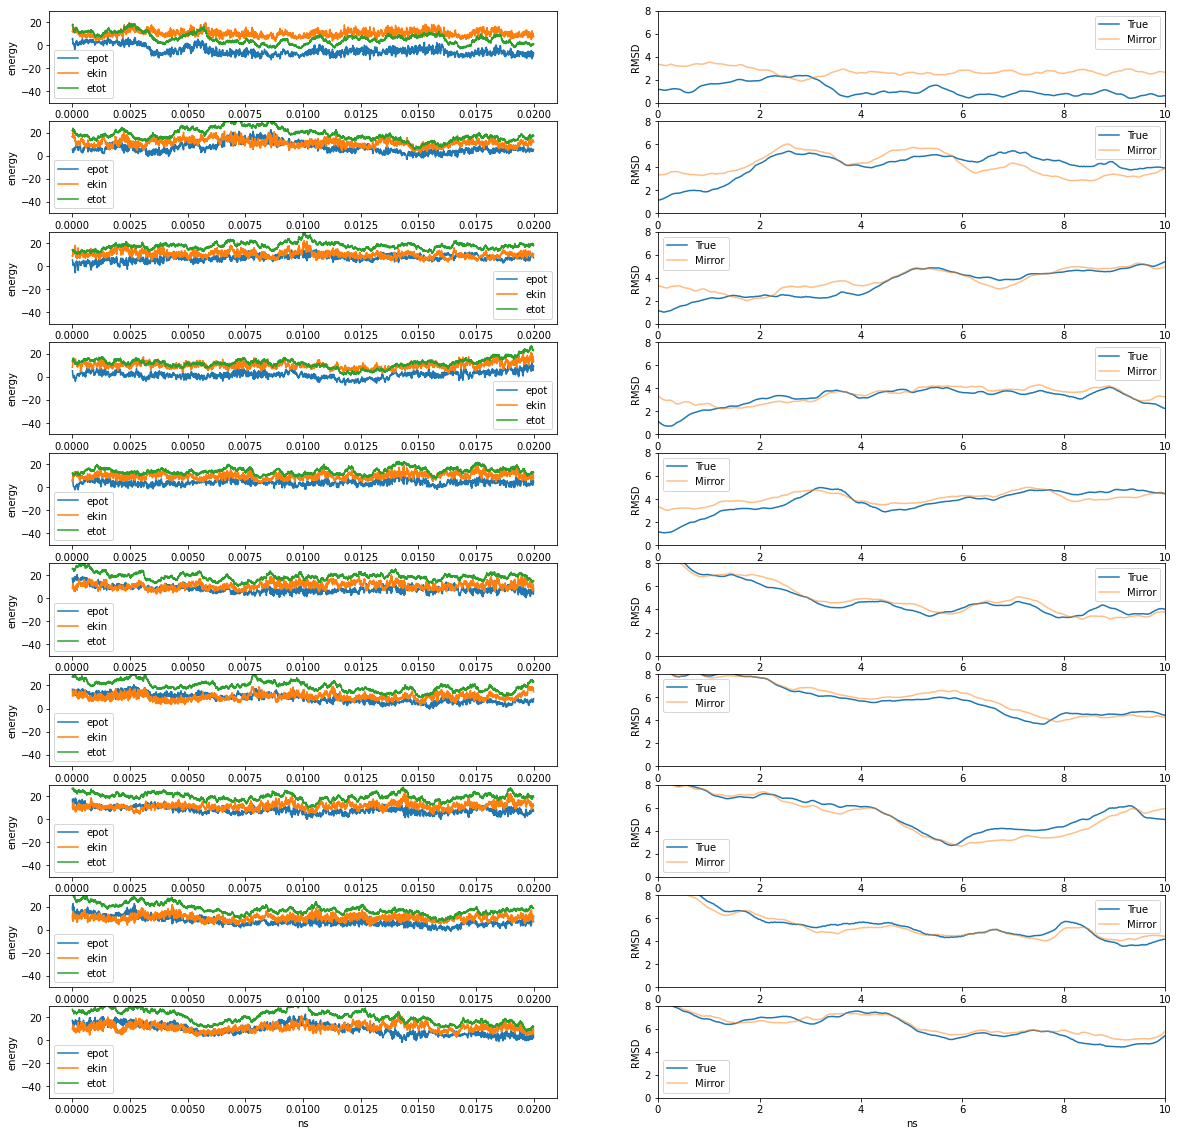

In [33]:
out_dir = 'cln_64trajs_350_ts1'
ts = 0.001
n_traj = 10

fig, ax = plt.subplots(nrows = n_traj, ncols = 2, figsize=[20, 2*n_traj])

for n, axi in enumerate(ax):
    
    # Plot energy from monitor file
    df = pd.read_csv(f'{out_dir}/monitor_{n}.csv')
    df.plot(x='ns', y=['epot', 'ekin', 'etot'], ax =axi[0])
    axi[0].set_ylabel('energy')
    axi[0].legend()
    axi[0].set_ylim([-50, 30])
    
    # now plot the RMSD to refernece molecule 
    
    # load a reference from data/chignolin_cln025.pdb file and filter only CA atoms
    mol_ref = Molecule('data/chignolin_cln025.pdb')
    mol_ref.filter('name CA')
    
    # load an array with trajectory and replace the coord array in molecule object
    mol = Molecule('data/cln_ca_top_dih.psf')
    arr = np.load(f'{out_dir}/output_{n}.npy')
    mol.coords = arr.astype(np.float32)

    # align trajectory (mol) to the reference (mol_ref)
    mol.align('name CA', refmol=mol_ref)
    
    # compute RMSD with MetricRmsd
    rmsd_proj = MetricRmsd(mol_ref, 'name CA', centerstr='name CA', pbc=False)
    rmsd = rmsd_proj.project(mol)
    
    # plot the result
    axi[1].plot(np.arange(len(rmsd))*ts, rmsd, label='True')

    # repeat the process for mirror image of the molecule.
    mul = np.ones_like(arr)
    mul[:,2,:] = -1
    arr *= mul
    
    # replace the coordinates in mol object
    mol.coords = (arr).astype(np.float32)
    
    # align
    mol.align('name CA', refmol=mol_ref)
    
    # compute RMSD
    rmsd_proj = MetricRmsd(mol_ref, 'name CA', centerstr='name CA', pbc=False)
    rmsd = rmsd_proj.project(mol)
    
    # plot
    axi[1].plot(np.arange(len(rmsd))*ts, rmsd, label = 'Mirror', alpha=0.5)
    axi[1].set_ylim([0,8])
    axi[1].set_xlim([0,10])
    axi[1].set_xlabel('ns')
    axi[1].set_ylabel('RMSD')
    axi[1].legend()
    
plt.show()


## Load NN

In [66]:
from torchmdnet.calculators import External
import importlib

import argparse
import importlib
from moleculekit.molecule import Molecule
from moleculekit.projections.metricrmsd import MetricRmsd
import os
import torch
from torchmd_cg.utils.psfwriter import pdb2psf_CA
from torchmd.utils import save_argparse, LogWriter,LoadFromFile
from torchmd.forcefields.ff_yaml import YamlForcefield
from torchmd.forcefields.forcefield import ForceField
from torchmd.forces import Forces
from torchmd.integrator import Integrator, maxwell_boltzmann
from torchmd.parameters import Parameters
from torchmd.systems import System
from torchmd.wrapper import Wrapper
from tqdm import tqdm
from utils import rmsd


In [67]:
import torch
from torchmdnet.models.model import load_model


class External:
    def __init__(self, netfile, embeddings, device="cpu"):
        self.model = load_model(netfile, device=device, derivative=True)
        self.device = device
        self.n_atoms = embeddings.size(1)
        self.embeddings = embeddings.reshape(-1).to(device)
        self.batch = torch.arange(embeddings.size(0), device=device).repeat_interleave(
            embeddings.size(1)
        )
        self.model.eval()

    def calculate(self, pos, box):
        pos = pos.to(self.device).type(torch.float32).reshape(-1, 3)
        energy, forces = self.model(self.embeddings, pos, self.batch)
        return energy.detach(), forces.reshape(-1, self.n_atoms, 3)


In [68]:
# Molecule
mol = Molecule('data/chignolin_cln025.pdb')
mol.filter('name CA')
mol.read('data/chignolin_ca_top.psf')
mol.read('data/chignolin_ca_initial_coords.xtc')

2021-08-24 17:00:58,127 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


In [69]:
# Loading the model as external force

embeddings = [4, 4, 5, 8, 6, 13, 2, 13, 7, 4]
#model = torch.load('data/epoch=47-val_loss=739.5398-test_loss=21.5975.ckpt')
device = 'cpu'

externalmodule = importlib.import_module('torchmdnet.calculators')
embeddings = torch.tensor(embeddings).repeat(10, 1)
external = External('data/epoch=47-val_loss=739.5398-test_loss=21.5975.ckpt', embeddings, device)

In [70]:
ff = ForceField.create(mol,'/shared/carles/torchMD-DMS/nn/data/ca_priors-dihedrals_general_2xweaker.yaml')
cln_parameters = Parameters(ff, mol, terms=['bonds', 'repulsionCG', 'dihedrals'], device=device)
forces = Forces(cln_parameters, terms=['bonds', 'repulsionCG', 'dihedrals'], external=external, cutoff=None, 
                rfa=False, switch_dist=None
                )

In [71]:
# System
system = System(mol.numAtoms, nreplicas=10,precision=torch.double, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(forces.par.masses, T=350, replicas=10))

In [72]:
integrator = Integrator(system, forces, 1, device, gamma=0.1, T=0)
native_coords = system.pos.clone()
ref_coords = mol.coords.copy()

In [73]:
# hparameters

steps = 200
output_period = 10
n_epochs = 20
iterator = tqdm(range(1,int(steps/output_period)+1))

learning_rate = 0.1
optim = torch.optim.Adam(forces.external.model.parameters(), lr=learning_rate)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

In [74]:
train_losses = []
for epoch in range(1, n_epochs + 1):
            
    # Starting...

    system = System(mol.numAtoms, nreplicas=10,precision=torch.double, device=device)
    system.set_positions(mol.coords)
    system.set_box(mol.box)
    system.set_velocities(maxwell_boltzmann(forces.par.masses, T=350, replicas=10))

    Epot = forces.compute(system.pos, system.box, system.forces)
    
    
    for i in iterator:
        Ekin, Epot, T = integrator.step(niter=output_period)
        #currpos = system.pos.detach().cpu().numpy().copy()
    
    # Update params
    
    loss, passed = rmsd(native_coords[0], system.pos.clone()[0])
    train_losses.append(loss)
    loss_log = torch.log(1.0 + loss)
    
    optim.zero_grad()
    loss_log.backward()
    optim.step()
    
    del system
    print(f'Epoch {epoch}, Training loss {loss.item()}')
        
    
    #for rep, coords in enumerate(native_coords):
    #    print('RMSD GOOD: ', rmsd(native_coords[rep], currpos[rep]))
    

100%|███████████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [26]:
ref_coords = mol.coords.copy()
ref_coords

array([[[ -6.88      ,  -6.88      ,  -6.88      ,  -6.88      ,
          -6.88      ,  -9.8       ,  -9.8       ,  -9.8       ,
          -9.8       ,  -9.8       ],
        [ -0.71000004,  -0.71000004,  -0.71000004,  -0.71000004,
          -0.71000004,  11.51      ,  11.51      ,  11.51      ,
          11.51      ,  11.51      ],
        [  2.9       ,   2.9       ,   2.9       ,   2.9       ,
           2.9       ,   1.26      ,   1.26      ,   1.26      ,
           1.26      ,   1.26      ]],

       [[ -4.1900005 ,  -4.1900005 ,  -4.1900005 ,  -4.1900005 ,
          -4.1900005 ,  -8.52      ,  -8.52      ,  -8.52      ,
          -8.52      ,  -8.52      ],
        [ -0.3       ,  -0.3       ,  -0.3       ,  -0.3       ,
          -0.3       ,   7.8500004 ,   7.8500004 ,   7.8500004 ,
           7.8500004 ,   7.8500004 ],
        [  0.21000001,   0.21000001,   0.21000001,   0.21000001,
           0.21000001,   1.72      ,   1.72      ,   1.72      ,
           1.72      ,   1.7

In [16]:
for i in iterator:
         #viewFrame(mol, system.pos, system.forces)
    Ekin, Epot, T = integrator.step(niter=output_period)
#wrapper.wrap(system.pos, system.box)
    currpos = system.pos.clone()


100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


In [17]:
rmsd(native_coords[0], currpos[0])

(tensor(1.6575, dtype=torch.float64), True)